In [1]:
from dotenv import load_dotenv
import sys, os
sys.path.append('../')
from utilities.seed import seed_everything
seed_everything()
load_dotenv('../.env')

True

## Experiment Settings

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

tuning_df = pd.read_csv(os.getenv('TUNING_CSV'))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = [
    (tuning_df.iloc[train_idx].reset_index(drop=True), tuning_df.iloc[val_idx].reset_index(drop=True))
    for train_idx, val_idx in kf.split(tuning_df)
]

# Fold 1개만 적용 
train_df, valid_df = folds[0]
train_df

,image_filename,mask_save_path
0,311.png,311.png
1,00086.png,00086.png
2,200.png,200.png
3,319.png,319.png
4,00136.png,00136.png
...,...,...
123,00155.png,00155.png
124,00091.png,00091.png
125,00114.png,00114.png
126,00197.png,00197.png


## Dataset Setting

/home/medisc/miniconda3/envs/eiden/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:63: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @amp.custom_fwd(cast_inputs=torch.float32)
/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:89: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/medisc/eiden/SNUH_AI_Research_2025/source/tutorials/../utilities/losses/label_smooth.py:131: Fu

torch.Size([16, 1, 512, 512]) torch.Size([16, 1, 512, 512])
tensor([0., 1.])


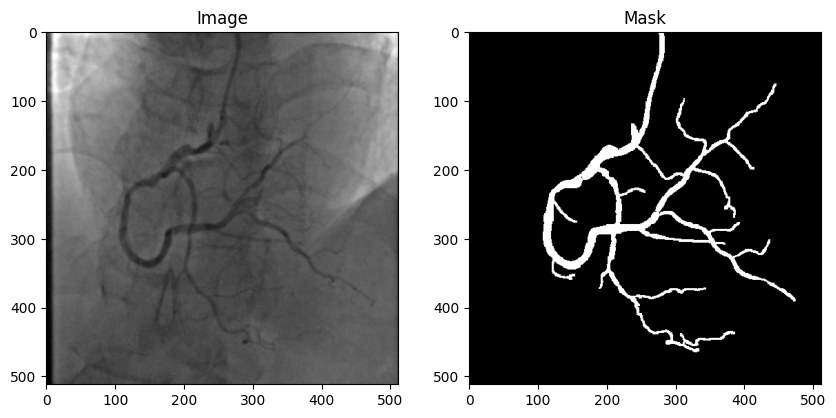

In [3]:
from torch.utils.data import DataLoader
from utilities.datasets import CAG_Dataset
from Args import Args_Train_Loader, Args_Valid_Loader

Train_Dataset = CAG_Dataset(
    df=train_df,
    image_dir=os.getenv('IMAGE_DIR'),
    mask_dir=os.getenv('MASK_DIR'),
    default_transform = Args_Train_Loader._get_default_transform(),
    aug_transform = Args_Train_Loader._get_aug_transform()
)
Valid_Dataset = CAG_Dataset(
    df=valid_df,
    image_dir=os.getenv('IMAGE_DIR'),
    mask_dir=os.getenv('MASK_DIR'),
    default_transform = Args_Valid_Loader._get_default_transform(),
    # Prompt_Args = {
    #     "n_shot" : 3
    # }
)

Train_Loader = DataLoader(
    Train_Dataset,
    batch_size=Args_Train_Loader.train_bs,
    shuffle=Args_Train_Loader.shuffle,
    num_workers=Args_Train_Loader.num_workers,
    pin_memory=Args_Train_Loader.pin_memory,
    drop_last=Args_Train_Loader.drop_last,

)
Valid_Loader = DataLoader(
    Valid_Dataset,
    batch_size=Args_Valid_Loader.valid_bs,
    shuffle=Args_Valid_Loader.shuffle,
    num_workers=Args_Valid_Loader.num_workers,
    pin_memory=Args_Valid_Loader.pin_memory,
    drop_last=Args_Valid_Loader.drop_last,
)

sample_imgs, sample_masks = next(iter(Train_Loader))
print(sample_imgs.shape, sample_masks.shape)
print(sample_masks.unique())
# sample_imgs, sample_masks 에 하나만 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_imgs[0].squeeze().cpu().numpy(), cmap = 'gray')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_masks[0].squeeze().cpu().numpy(), cmap = 'gray')
plt.title('Mask')
plt.show()



# Model Setting

In [ ]:
from Args import Args_experiments
import torch.nn as nn
from torchinfo import summary

from models.deepsa import UNet
from models.deepsa import build_model as build_model_deepsa
from models.unet_plus_plus import build_model as build_model_unetpp
from models.unetresnet50_dino import build_model as build_model_unetresnet50_dino
# from models.unet_swin import build_model as build_model_unetswin

exp_name = "DeepSA-ft-BCE"

# seg_model = UNet(1, 1, 32, bilinear=True).to(Args_experiments.device)
seg_model = build_model_deepsa(ckpt_path = os.getenv('deepsa_ckpt_path'), device = Args_experiments.device).to(Args_experiments.device)
# seg_model = build_model_unetpp(device = Args_experiments.device).to(Args_experiments.device)
# seg_model = build_model_unetresnet50_dino(device = Args_experiments.device).to(Args_experiments.device) 
# seg_model = build_model_unetswin(device = Args_experiments.device).to(Args_experiments.device) # [FIX]


seg_model = nn.DataParallel(seg_model, device_ids=Args_experiments.device_ids)


/home/medisc/miniconda3/envs/eiden/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(


## Training Setting

In [5]:

optimizer = Args_experiments.optimizer_fn(seg_model.parameters())
scheduler = Args_experiments.scheduler_fn(optimizer)
loss_fn = Args_experiments.loss_fn()

In [6]:
import torch
from tqdm import tqdm
import os
from utilities.metrics import SegmentationMetrics

metrics = SegmentationMetrics()

def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss, metric_sum = 0, None
    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item() * imgs.size(0)
        batch_metrics = metrics.evaluate(torch.sigmoid(outputs), masks)
        if metric_sum is None:
            metric_sum = {k: v * imgs.size(0) for k, v in batch_metrics.items()}
        else:
            for k in metric_sum:
                metric_sum[k] += batch_metrics[k] * imgs.size(0)
    n = len(loader.dataset)
    avg_metrics = {k: v / n for k, v in metric_sum.items()}
    return epoch_loss / n, avg_metrics

@torch.no_grad()
def valid_one_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss, metric_sum = 0, None
    for imgs, masks in tqdm(loader, desc="Valid", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        epoch_loss += loss.item() * imgs.size(0)
        batch_metrics = metrics.evaluate(torch.sigmoid(outputs), masks)
        if metric_sum is None:
            metric_sum = {k: v * imgs.size(0) for k, v in batch_metrics.items()}
        else:
            for k in metric_sum:
                metric_sum[k] += batch_metrics[k] * imgs.size(0)
    n = len(loader.dataset)
    avg_metrics = {k: v / n for k, v in metric_sum.items()}
    return epoch_loss / n, avg_metrics

def run_training(
    model, optimizer, scheduler, loss_fn, 
    train_loader, valid_loader, device, 
    num_epochs, patience, exp_name
):
    best_dice = 0
    best_valid_loss = float('inf')
    patience_counter = 0
    save_dir = os.path.join(os.getenv("EXPERIMENT_DIR", "./EXPERIMENT_DIR"), exp_name)
    os.makedirs(save_dir, exist_ok=True)
    best_weight_dice_path = os.path.join(save_dir, "best_weight.pth")
    warmup_epoch = getattr(Args_experiments, "warmup_epoch", 0)
    base_lr = Args_experiments.lr
    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        if warmup_epoch > 0 and epoch <= warmup_epoch:
            warmup_lr = base_lr * epoch / warmup_epoch
            set_lr(optimizer, warmup_lr)
            print(f"Warmup lr: {get_lr(optimizer):.6f}")
        elif warmup_epoch > 0 and epoch == warmup_epoch + 1:
            set_lr(optimizer, base_lr)
            print(f"Set lr to base: {get_lr(optimizer):.6f}")
        train_loss, train_metrics = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_metrics = valid_one_epoch(model, valid_loader, loss_fn, device)
        scheduler.step()
        # dice 기준 best
        if valid_metrics["dice_coef"] > best_dice:
            best_dice = valid_metrics["dice_coef"]
            patience_counter = 0
            torch.save(model.state_dict(), best_weight_dice_path)
            print(f"[Best Dice] Train Loss: {train_loss:.4f} | " + " | ".join([f'{k}: {v:.4f}' for k, v in train_metrics.items()]))
            print(f"[Best Dice] Valid Loss: {valid_loss:.4f} | " + " | ".join([f'{k}: {v:.4f}' for k, v in valid_metrics.items()]))
            print(f"Best Dice model saved at {best_weight_dice_path} (Dice: {best_dice:.4f})")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
        # loss 기준 best
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

num_epochs = Args_experiments.epoch
patience = Args_experiments.patience

run_training(
    seg_model, optimizer, scheduler, loss_fn,
    Train_Loader, Valid_Loader, Args_experiments.device,
    num_epochs, patience, exp_name
)

Epoch 1/100
Warmup lr: 0.004200


[Best Dice] Train Loss: 0.1803 | pixel_accuracy: 0.9619 | mean_pixel_accuracy: 0.7758 | iou: 0.4640 | precision: 0.7159 | recall: 0.5867 | f1_score: 0.6355 | dice_coef: 0.6222
[Best Dice] Valid Loss: 0.1258 | pixel_accuracy: 0.9687 | mean_pixel_accuracy: 0.7730 | iou: 0.5082 | precision: 0.8436 | recall: 0.5725 | f1_score: 0.6814 | dice_coef: 0.6703
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.6703)
Epoch 2/100
Warmup lr: 0.008400


Patience: 1/20
Epoch 3/100
Warmup lr: 0.012600


[Best Dice] Train Loss: 0.0973 | pixel_accuracy: 0.9667 | mean_pixel_accuracy: 0.7890 | iou: 0.5066 | precision: 0.7828 | recall: 0.6134 | f1_score: 0.6860 | dice_coef: 0.6681
[Best Dice] Valid Loss: 0.0837 | pixel_accuracy: 0.9692 | mean_pixel_accuracy: 0.7775 | iou: 0.5148 | precision: 0.8415 | recall: 0.5839 | f1_score: 0.6883 | dice_coef: 0.6756
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.6756)
Epoch 4/100
Warmup lr: 0.016800


[Best Dice] Train Loss: 0.0875 | pixel_accuracy: 0.9688 | mean_pixel_accuracy: 0.8007 | iou: 0.5304 | precision: 0.7942 | recall: 0.6329 | f1_score: 0.7032 | dice_coef: 0.6895
[Best Dice] Valid Loss: 0.0763 | pixel_accuracy: 0.9706 | mean_pixel_accuracy: 0.8408 | iou: 0.5716 | precision: 0.7617 | recall: 0.7173 | f1_score: 0.7371 | dice_coef: 0.7231
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7231)
Epoch 5/100
Warmup lr: 0.021000


Patience: 1/20
Epoch 6/100
Warmup lr: 0.025200


[Best Dice] Train Loss: 0.0857 | pixel_accuracy: 0.9684 | mean_pixel_accuracy: 0.8252 | iou: 0.5468 | precision: 0.7575 | recall: 0.6874 | f1_score: 0.7170 | dice_coef: 0.7031
[Best Dice] Valid Loss: 0.0731 | pixel_accuracy: 0.9735 | mean_pixel_accuracy: 0.8250 | iou: 0.5883 | precision: 0.8360 | recall: 0.6819 | f1_score: 0.7497 | dice_coef: 0.7383
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7383)
Epoch 7/100
Warmup lr: 0.029400


Patience: 1/20
Epoch 8/100
Warmup lr: 0.033600


Patience: 2/20
Epoch 9/100
Warmup lr: 0.037800


Patience: 3/20
Epoch 10/100
Warmup lr: 0.042000


Patience: 4/20
Epoch 11/100
Set lr to base: 0.042000


Patience: 5/20
Epoch 12/100


[Best Dice] Train Loss: 0.0787 | pixel_accuracy: 0.9704 | mean_pixel_accuracy: 0.8165 | iou: 0.5533 | precision: 0.8015 | recall: 0.6581 | f1_score: 0.7173 | dice_coef: 0.7065
[Best Dice] Valid Loss: 0.0710 | pixel_accuracy: 0.9726 | mean_pixel_accuracy: 0.8682 | iou: 0.6039 | precision: 0.7539 | recall: 0.7679 | f1_score: 0.7598 | dice_coef: 0.7502
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7502)
Epoch 13/100


[Best Dice] Train Loss: 0.0767 | pixel_accuracy: 0.9714 | mean_pixel_accuracy: 0.8401 | iou: 0.5806 | precision: 0.7790 | recall: 0.7122 | f1_score: 0.7429 | dice_coef: 0.7319
[Best Dice] Valid Loss: 0.0681 | pixel_accuracy: 0.9748 | mean_pixel_accuracy: 0.8310 | iou: 0.6061 | precision: 0.8489 | recall: 0.6918 | f1_score: 0.7616 | dice_coef: 0.7525
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7525)
Epoch 14/100


Patience: 1/20
Epoch 15/100


[Best Dice] Train Loss: 0.0709 | pixel_accuracy: 0.9734 | mean_pixel_accuracy: 0.8370 | iou: 0.5949 | precision: 0.8157 | recall: 0.7007 | f1_score: 0.7528 | dice_coef: 0.7433
[Best Dice] Valid Loss: 0.0658 | pixel_accuracy: 0.9753 | mean_pixel_accuracy: 0.8408 | iou: 0.6143 | precision: 0.8382 | recall: 0.7081 | f1_score: 0.7669 | dice_coef: 0.7590
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7590)
Epoch 16/100


[Best Dice] Train Loss: 0.0689 | pixel_accuracy: 0.9739 | mean_pixel_accuracy: 0.8450 | iou: 0.6037 | precision: 0.8099 | recall: 0.7154 | f1_score: 0.7590 | dice_coef: 0.7501
[Best Dice] Valid Loss: 0.0646 | pixel_accuracy: 0.9755 | mean_pixel_accuracy: 0.8382 | iou: 0.6157 | precision: 0.8487 | recall: 0.7006 | f1_score: 0.7671 | dice_coef: 0.7607
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7607)
Epoch 17/100


[Best Dice] Train Loss: 0.0676 | pixel_accuracy: 0.9744 | mean_pixel_accuracy: 0.8437 | iou: 0.6097 | precision: 0.8241 | recall: 0.7122 | f1_score: 0.7636 | dice_coef: 0.7551
[Best Dice] Valid Loss: 0.0636 | pixel_accuracy: 0.9759 | mean_pixel_accuracy: 0.8396 | iou: 0.6191 | precision: 0.8507 | recall: 0.7024 | f1_score: 0.7690 | dice_coef: 0.7626
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7626)
Epoch 18/100


[Best Dice] Train Loss: 0.0663 | pixel_accuracy: 0.9746 | mean_pixel_accuracy: 0.8517 | iou: 0.6152 | precision: 0.8128 | recall: 0.7279 | f1_score: 0.7677 | dice_coef: 0.7593
[Best Dice] Valid Loss: 0.0629 | pixel_accuracy: 0.9761 | mean_pixel_accuracy: 0.8416 | iou: 0.6245 | precision: 0.8545 | recall: 0.7067 | f1_score: 0.7731 | dice_coef: 0.7673
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7673)
Epoch 19/100


Patience: 1/20
Epoch 20/100


Patience: 2/20
Epoch 21/100


Patience: 3/20
Epoch 22/100


Patience: 4/20
Epoch 23/100


[Best Dice] Train Loss: 0.0651 | pixel_accuracy: 0.9752 | mean_pixel_accuracy: 0.8523 | iou: 0.6201 | precision: 0.8221 | recall: 0.7262 | f1_score: 0.7707 | dice_coef: 0.7631
[Best Dice] Valid Loss: 0.0627 | pixel_accuracy: 0.9761 | mean_pixel_accuracy: 0.8443 | iou: 0.6251 | precision: 0.8484 | recall: 0.7118 | f1_score: 0.7736 | dice_coef: 0.7677
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7677)
Epoch 24/100


[Best Dice] Train Loss: 0.0651 | pixel_accuracy: 0.9751 | mean_pixel_accuracy: 0.8520 | iou: 0.6186 | precision: 0.8209 | recall: 0.7247 | f1_score: 0.7695 | dice_coef: 0.7615
[Best Dice] Valid Loss: 0.0625 | pixel_accuracy: 0.9762 | mean_pixel_accuracy: 0.8439 | iou: 0.6254 | precision: 0.8508 | recall: 0.7100 | f1_score: 0.7736 | dice_coef: 0.7679
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7679)
Epoch 25/100


[Best Dice] Train Loss: 0.0653 | pixel_accuracy: 0.9749 | mean_pixel_accuracy: 0.8461 | iou: 0.6132 | precision: 0.8300 | recall: 0.7124 | f1_score: 0.7654 | dice_coef: 0.7578
[Best Dice] Valid Loss: 0.0619 | pixel_accuracy: 0.9765 | mean_pixel_accuracy: 0.8482 | iou: 0.6299 | precision: 0.8473 | recall: 0.7182 | f1_score: 0.7769 | dice_coef: 0.7714
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7714)
Epoch 26/100


Patience: 1/20
Epoch 27/100


[Best Dice] Train Loss: 0.0650 | pixel_accuracy: 0.9752 | mean_pixel_accuracy: 0.8476 | iou: 0.6176 | precision: 0.8327 | recall: 0.7146 | f1_score: 0.7686 | dice_coef: 0.7611
[Best Dice] Valid Loss: 0.0605 | pixel_accuracy: 0.9772 | mean_pixel_accuracy: 0.8503 | iou: 0.6388 | precision: 0.8581 | recall: 0.7205 | f1_score: 0.7828 | dice_coef: 0.7784
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7784)
Epoch 28/100


Patience: 1/20
Epoch 29/100


Patience: 2/20
Epoch 30/100


Patience: 3/20
Epoch 31/100


[Best Dice] Train Loss: 0.0650 | pixel_accuracy: 0.9750 | mean_pixel_accuracy: 0.8470 | iou: 0.6134 | precision: 0.8321 | recall: 0.7131 | f1_score: 0.7650 | dice_coef: 0.7579
[Best Dice] Valid Loss: 0.0613 | pixel_accuracy: 0.9762 | mean_pixel_accuracy: 0.8779 | iou: 0.6452 | precision: 0.7975 | recall: 0.7799 | f1_score: 0.7882 | dice_coef: 0.7833
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7833)
Epoch 32/100


Patience: 1/20
Epoch 33/100


Patience: 2/20
Epoch 34/100


Patience: 3/20
Epoch 35/100


Patience: 4/20
Epoch 36/100


Patience: 5/20
Epoch 37/100


Patience: 6/20
Epoch 38/100


Patience: 7/20
Epoch 39/100


Patience: 8/20
Epoch 40/100


Patience: 9/20
Epoch 41/100


Patience: 10/20
Epoch 42/100


Patience: 11/20
Epoch 43/100


Patience: 12/20
Epoch 44/100


Patience: 13/20
Epoch 45/100


Patience: 14/20
Epoch 46/100


Patience: 15/20
Epoch 47/100


Patience: 16/20
Epoch 48/100


Patience: 17/20
Epoch 49/100


Patience: 18/20
Epoch 50/100


[Best Dice] Train Loss: 0.0595 | pixel_accuracy: 0.9770 | mean_pixel_accuracy: 0.8600 | iou: 0.6424 | precision: 0.8488 | recall: 0.7349 | f1_score: 0.7862 | dice_coef: 0.7802
[Best Dice] Valid Loss: 0.0589 | pixel_accuracy: 0.9772 | mean_pixel_accuracy: 0.8678 | iou: 0.6487 | precision: 0.8296 | recall: 0.7538 | f1_score: 0.7895 | dice_coef: 0.7858
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7858)
Epoch 51/100


Patience: 1/20
Epoch 52/100


Patience: 2/20
Epoch 53/100


Patience: 3/20
Epoch 54/100


Patience: 4/20
Epoch 55/100


Patience: 5/20
Epoch 56/100


[Best Dice] Train Loss: 0.0549 | pixel_accuracy: 0.9783 | mean_pixel_accuracy: 0.8697 | iou: 0.6621 | precision: 0.8546 | recall: 0.7526 | f1_score: 0.7997 | dice_coef: 0.7949
[Best Dice] Valid Loss: 0.0579 | pixel_accuracy: 0.9774 | mean_pixel_accuracy: 0.8677 | iou: 0.6507 | precision: 0.8355 | recall: 0.7507 | f1_score: 0.7905 | dice_coef: 0.7874
Best Dice model saved at /home/medisc/eiden/SNUH_AI_Research_2025/source/logs/DeepSA-ft-BCE/best_weight.pth (Dice: 0.7874)
Epoch 57/100


Patience: 1/20
Epoch 58/100


Patience: 2/20
Epoch 59/100


Patience: 3/20
Epoch 60/100


Patience: 4/20
Epoch 61/100


Patience: 5/20
Epoch 62/100


Patience: 6/20
Epoch 63/100


Patience: 7/20
Epoch 64/100


Patience: 8/20
Epoch 65/100


Patience: 9/20
Epoch 66/100


Patience: 10/20
Epoch 67/100


Patience: 11/20
Epoch 68/100


Patience: 12/20
Epoch 69/100


Patience: 13/20
Epoch 70/100


Patience: 14/20
Epoch 71/100


Patience: 15/20
Epoch 72/100


Patience: 16/20
Epoch 73/100


Patience: 17/20
Epoch 74/100


Patience: 18/20
Epoch 75/100


Patience: 19/20
Epoch 76/100


Patience: 20/20
Early stopping triggered.


## Model Series

### MedSegDiff

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
import torch
print(torch.cuda.device_count()) 

import sys
sys.path.append('../')
from models.med_seg_diff import build_model as build_model_med_seg_diff
from Args import Args_experiments
seg_model = build_model_med_seg_diff(device = Args_experiments.device)
import torch
segmented_imgs = torch.rand(8, 1, 224, 224)  # inputs are normalized from 0 to 1
input_imgs = torch.rand(8, 1, 224, 224)

loss = seg_model(segmented_imgs, input_imgs)
loss.backward()

# after a lot of training
pred = seg_model.sample(input_imgs)     # pass in your unsegmented images
pred.shape                              # predicted segmented images - (8, 3, 128, 128)


2


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 